In [1]:
library(tidyverse)
library(ggthemes)

── Attaching packages ──────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.8
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.0.2     ✔ forcats 0.5.1

Warning message:
“package ‘ggplot2’ was built under R version 4.1.1”
Warning message:
“package ‘tibble’ was built under R version 4.1.1”
Warning message:
“package ‘tidyr’ was built under R version 4.1.1”
Warning message:
“package ‘readr’ was built under R version 4.1.1”
Warning message:
“package ‘dplyr’ was built under R version 4.1.1”
Warning message:
“package ‘stringr’ was built under R version 4.1.1”
Warning message:
“package ‘forcats’ was built under R version 4.1.1”
── Conflicts ─────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [2]:
RSS <- function(yObs, yFit)
{
    # RSS: Compute the residual sums of squares
    # yObs: the observed response y
    # yFit: the fitted response y
    return(sum((yObs - yFit)^2))
}

In [3]:
ASE <- function(yTruth, yFit)
{
    # ASE: Compute the mean average squared error
    # yObs: the observed response y
    # yFit: the fitted response y
    return(mean((yTruth - yFit)^2))
}

In [4]:
library(mgcv) # penalised regression splines
library(MRSea) # SALSA
# Read simulated dataset from Moodle
df <- read.csv("SimulatedData.csv")

Loading required package: nlme


Attaching package: ‘nlme’


The following object is masked from ‘package:dplyr’:

    collapse


This is mgcv 1.8-35. For overview type 'help("mgcv-package")'.


Attaching package: ‘MRSea’


The following object is masked from ‘package:dplyr’:

    contains


The following object is masked from ‘package:tidyr’:

    contains




In [6]:
square_residuals = c()
abs_residuals = c()
fitted = c()
for (i in seq(100))
{
    # Subset dataset
    dfSub <- subset(df, ID %in% i)
    poly_model = lm(response ~ poly(x, degree=6), data=dfSub)
    predictions = predict(poly_model, dfSub)
    fitted = c(fitted, predictions)
    sq_res = RSS(df$x, predictions)
    abs_res = ASE(df$x, predictions)
    square_residuals = c(square_residuals, sq_res)
    abs_residuals = c(abs_residuals, abs_res)
}

df = df %>% add_column(fitted = fitted)
ggplot(aes(fitted, response), data=df) + geom_point() 

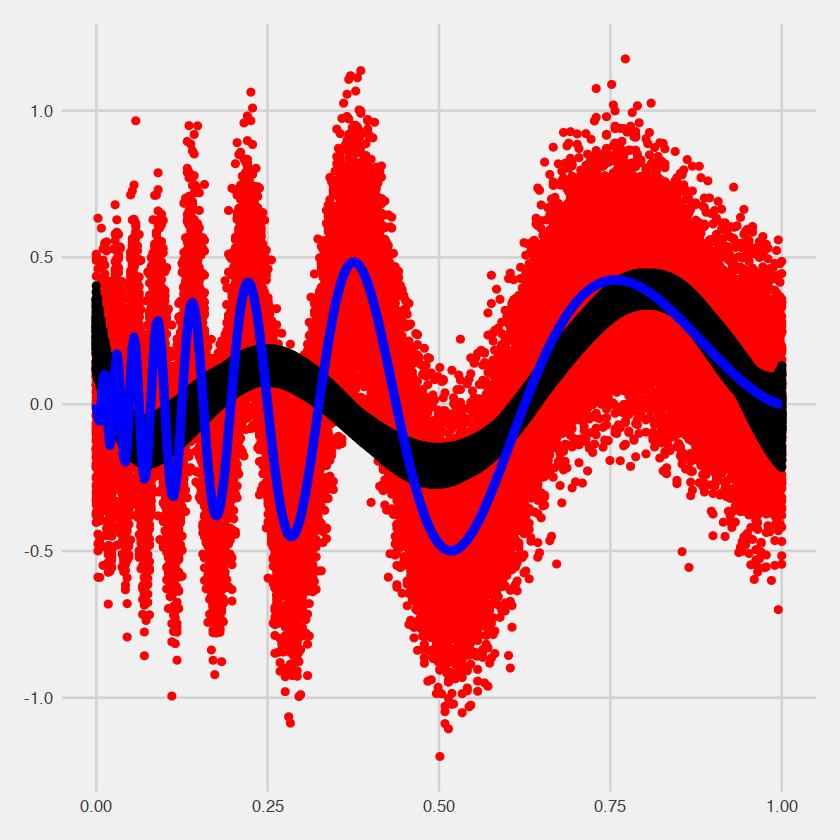

In [38]:
ggplot(data=df) + geom_point(aes(x=x, y=response), colour="red") + 
geom_point(aes(x=x, y=fitted)) + 
geom_line(aes(x=x, y=mu), colour="blue", size=2) + 
theme_fivethirtyeight(base_size = 12, base_family = "sans")

In [ ]:
?geom_line